In [66]:
MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#    "FI-23",
#    "FI-20",
#   "FI-20/FI-23",
#    "TI-22",
#    "delta_t",
    "TI-35",
#     "delta_t_2"
]

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [67]:
def transform_data(train_tuple: tuple, test_tuples: List[tuple]):
    """Scale data using minmax scaling

    Args:
        train_tuple (tuple): tuple of darts time series for training
        test_tuples (List[tuple]): tuples (x,y) of darts time series for testing

    Returns:
        tuple: tuple of time series for training, test tuples and transformers
    """
    x_train, y_train = train_tuple

    transformer = Scaler()

    x_train = transformer.fit_transform(x_train)

    y_transformer = Scaler(name="YScaler")
    y_train = y_transformer.fit_transform(y_train)

    transformed_test_tuples = []
    for x_test, y_test in test_tuples:
        print(x_test.pd_dataframe().shape, y_test.pd_dataframe().shape)
        x_test = transformer.transform(x_test)
        y_test = y_transformer.transform(y_test)
        transformed_test_tuples.append((x_test, y_test))

    return (x_train, y_train), transformed_test_tuples, (transformer, y_transformer)

In [80]:
from functools import partial
from typing import List, Optional, Sequence

import numpy as np
import pandas as pd
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.logging import raise_if_not
from darts.models import TCNModel
from darts.utils import _build_tqdm_iterator

from joblib import Parallel, delayed
from torch.utils.data import DataLoader

from darts.metrics import mape, mae

In [69]:
df = pd.read_pickle('../paper/20210624_df_cleaned.pkl')

In [70]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [71]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [72]:
def choose_index(series, fraction): 
    timestamps = series.time_index
    fraction_index = int(len(timestamps) * fraction)
    
    return timestamps[fraction_index]

def split_data(x, y, fraction_train, fraction_test=0.5):
    ts = choose_index(x, fraction_train)
    x_before, x_after = x.split_before(ts)
    y_before, y_after = y.split_before(ts)

    ts_2 = choose_index(x_after, fraction_test)

    x_valid, x_test = x_after.split_before(ts_2)
    y_valid, y_test = y_after.split_before(ts_2)
    
    return (x_before, y_before[TARGETS_clean]), (x_valid, y_valid[TARGETS_clean]), (x_test, y_test[TARGETS_clean])

In [73]:
train, valid, test  = split_data(x, y, 0.5)

In [74]:
model_cov = TCNModel(
    input_chunk_length=60,
    output_chunk_length=30,
    num_layers=8,
    num_filters=32,
    kernel_size=4,
    dropout=0.3,
    weight_norm=True,
    batch_size=32,
    n_epochs=300,
    log_tensorboard=True,
    optimizer_kwargs={"lr": 1e-5},
)

In [75]:
model_cov.fit(series=train[1], past_covariates=train[0], verbose=False)

[2022-01-10 15:33:39,297] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2615 samples.
[2022-01-10 15:33:39,297] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2615 samples.
[2022-01-10 15:33:39,301] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-10 15:33:39,301] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


In [78]:
backtest = model_cov.historical_forecasts(
    valid[1],
    past_covariates=valid[0],
    start=0.1,
    forecast_horizon=30,
    stride=1,
    retrain=False,
    verbose=False,
)

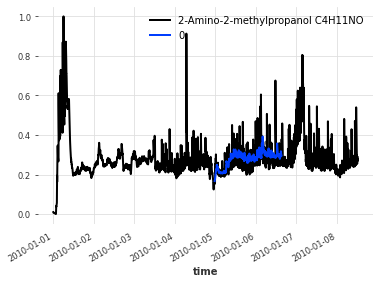

In [79]:

y[TARGETS_clean[0]].plot()
backtest['0'].plot()

In [84]:
mape(y[TARGETS_clean[0]], backtest['0'])

13.667006732593881

In [85]:
mae(y[TARGETS_clean[0]], backtest['0'])

0.038825308953792693